**Start**

##  Configuration 

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

DATA_PATH = '/kaggle/input/brain-tumor-segmentation-hackathon'
OUTPUT_DIR = '/kaggle/working'  


## Read Data

In [ ]:

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ===== Helper Functions =====

def find_nii_file(patient_dir, modality):
    
    direct_file = os.path.join(patient_dir, f'{os.path.basename(patient_dir)}_{modality}.nii')
    if os.path.isfile(direct_file):
        return direct_file
    
    folder_path = os.path.join(patient_dir, f'{os.path.basename(patient_dir)}_{modality}.nii')
    if os.path.isdir(folder_path):
        
        for file in os.listdir(folder_path):
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                return os.path.join(folder_path, file)
    
    # Pattern 3: Search recursively
    patient_name = os.path.basename(patient_dir)
    for root, dirs, files in os.walk(patient_dir):
        for file in files:
            if modality in file.lower() and (file.endswith('.nii') or file.endswith('.nii.gz')):
                return os.path.join(root, file)
    
    return None
def get_patient_files(patient_dir):
    
    files = {}
    modalities = ['t1', 't1ce', 't2', 'flair', 'seg']
    
    for mod in modalities:
        file_path = find_nii_file(patient_dir, mod)
        files[mod] = file_path
    
    return files

def is_complete_patient(files):
    
    return all(files.values())    

# **Visualization**

📂 Loading BraTS2021_01355...
    ✓ FLAIR Loaded
    ✓ T1 Loaded
    ✓ T1CE Loaded
    ✓ T2 Loaded
🖼️ Creating 2D Grid for slice 75...


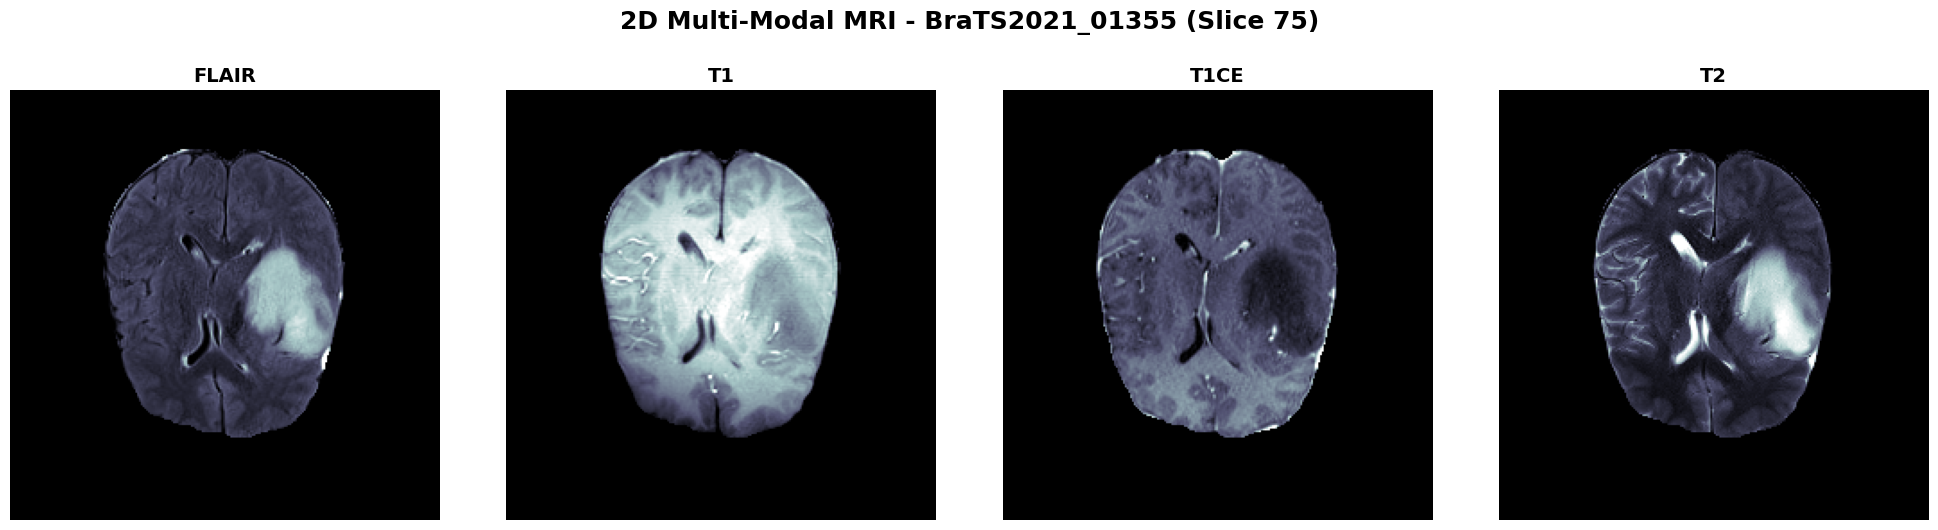

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from pathlib import Path

class MedicalViewer2D3D:
    def __init__(self, patient_path):
        self.patient_path = Path(patient_path)
        self.patient_id = self.patient_path.name
        self.modalities = {}
        
    def load_data(self):
    
        print(f"📂 Loading {self.patient_id}...")
        modalities_to_find = ['flair', 't1', 't1ce', 't2']
        
        for modality in modalities_to_find:
            pattern = f"**/*{modality}.nii*"
            files = list(self.patient_path.glob(pattern))
            
            valid_file = None
            for f in files:
                if f.is_file() and f.stat().st_size > 0:
                    valid_file = f
                    break
            
            if valid_file:
                try:
                    data = nib.load(str(valid_file)).get_fdata()
                    # Normalization
                    if (data > 0).sum() > 0:
                        p1, p99 = np.percentile(data[data > 0], (1, 99))
                        data = np.clip((data - p1) / (p99 - p1 + 1e-6), 0, 1)
                    
                    self.modalities[modality.upper()] = data
                    print(f"    ✓ {modality.upper()} Loaded")
                except Exception as e:
                    print(f"    ⚠️ Error in {modality}: {e}")
        return len(self.modalities) > 0

    def view_2d_grid(self, slice_idx=None, output='mri_2d_grid.png'):
       
        if not self.modalities: return
        
        first_mod = list(self.modalities.values())[0]
        if slice_idx is None:
            slice_idx = first_mod.shape[2] // 2
            
        print(f"🖼️ Creating 2D Grid for slice {slice_idx}...")
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        fig.suptitle(f'2D Multi-Modal MRI - {self.patient_id} (Slice {slice_idx})', 
                     fontsize=18, fontweight='bold', y=1.05)
        
        mod_names = ['FLAIR', 'T1', 'T1CE', 'T2']
        
        for i, name in enumerate(mod_names):
            if name in self.modalities:
              
                img = self.modalities[name][:, :, slice_idx]
                axes[i].imshow(np.rot90(img), cmap='bone') 
                axes[i].set_title(name, fontsize=14, fontweight='bold')
            else:
                axes[i].text(0.5, 0.5, 'Not Found', ha='center')
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.savefig(output, dpi=150, bbox_inches='tight')
        plt.show()


DATA_DIR = "/kaggle/input/brain-tumor-segmentation-hackathon"
TARGET_PATIENT = "BraTS2021_01355"

patient_path = os.path.join(DATA_DIR, TARGET_PATIENT)
viewer = MedicalViewer2D3D(patient_path)

if viewer.load_data():
   
    viewer.view_2d_grid(slice_idx=75) 
else:
    print("❌ Failed to load data.")

In [ ]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

sample = train_files[0]

flair = nib.load(sample["image"][3]).get_fdata()
mask  = nib.load(sample["label"]).get_fdata()

z = flair.shape[2] // 2

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(flair[:,:,z], cmap="gray")
plt.title("FLAIR")

plt.subplot(1,3,2)
plt.imshow(mask[:,:,z])
plt.title("Mask")

plt.subplot(1,3,3)
plt.imshow(flair[:,:,z], cmap="gray")
plt.imshow(mask[:,:,z], alpha=0.4)
plt.title("Overlay")

plt.show()


## Dataset Structure Analysis

In [ ]:


print("="*60)
print("📊 STEP 1: Dataset Structure Analysis")
print("="*60)

# Get all patient directories
all_items = os.listdir(DATA_PATH)
patient_dirs = [os.path.join(DATA_PATH, item) for item in all_items 
                if os.path.isdir(os.path.join(DATA_PATH, item)) and item.startswith('BraTS')]

print(f"\n✅ Found {len(patient_dirs)} patient directories")

# Analyze completeness
dataset_summary = []
incomplete_patients = []

print("\n🔍 Analyzing file completeness...")
for patient_dir in tqdm(patient_dirs):
    patient_id = os.path.basename(patient_dir)
    files = get_patient_files(patient_dir)
    
    is_complete = is_complete_patient(files)
    
    summary_row = {
        'patient_id': patient_id,
        'is_complete': is_complete,
        'has_t1': files['t1'] is not None,
        'has_t1ce': files['t1ce'] is not None,
        'has_t2': files['t2'] is not None,
        'has_flair': files['flair'] is not None,
        'has_seg': files['seg'] is not None,
        't1_path': files['t1'],
        't1ce_path': files['t1ce'],
        't2_path': files['t2'],
        'flair_path': files['flair'],
        'seg_path': files['seg']
    }
    
    dataset_summary.append(summary_row)
    
    if not is_complete:
        incomplete_patients.append(patient_id)

# Create DataFrame
df_summary = pd.DataFrame(dataset_summary)

# Save to CSV
summary_path = os.path.join(OUTPUT_DIR, 'dataset_summary.csv')
df_summary.to_csv(summary_path, index=False)
print(f"\n💾 Saved dataset summary to: {summary_path}")

# Print statistics
print(f"\n📈 Dataset Statistics:")
print(f"  Total patients: {len(df_summary)}")
print(f"  Complete patients: {df_summary['is_complete'].sum()}")
print(f"  Incomplete patients: {len(incomplete_patients)}")

if incomplete_patients:
    print(f"\n⚠️ Incomplete patients: {incomplete_patients[:10]}")  # أول 10 بس

# ===== STEP 2: Label Distribution Analysis (Imbalance Check) =====

print("\n" + "="*60)
print("📊 STEP 2: Label Distribution Analysis (Imbalance)")
print("="*60)


📊 STEP 1: Dataset Structure Analysis

✅ Found 1251 patient directories

🔍 Analyzing file completeness...


100%|██████████| 1251/1251 [00:03<00:00, 387.10it/s]



💾 Saved dataset summary to: /kaggle/working/dataset_summary.csv

📈 Dataset Statistics:
  Total patients: 1251
  Complete patients: 1251
  Incomplete patients: 0

📊 STEP 2: Label Distribution Analysis (Imbalance)


## Label Distribution Analysis (Imbalance Check)

In [ ]:

print("\n" + "="*60)
print("📊 STEP 2: Label Distribution Analysis (Imbalance)")
print("="*60)

# Filter only complete patients
complete_patients = df_summary[df_summary['is_complete'] == True]
print(f"\n✅ Analyzing {len(complete_patients)} complete patients...")

label_distributions = []
tumor_volumes = []
patient_ids_analyzed = []

print("\n🔬 Computing label distributions...")
for idx, row in tqdm(complete_patients.iterrows(), total=len(complete_patients)):
    try:
        # Load segmentation
        seg = nib.load(row['seg_path']).get_fdata()
        
        total_voxels = seg.size
        
        # Count each label
        label_counts = {
            'Background (0)': np.sum(seg == 0),
            'NCR (1)': np.sum(seg == 1),
            'ED (2)': np.sum(seg == 2),
            'ET (4)': np.sum(seg == 4)
        }
        
        # Convert to percentages
        label_percentages = {k: (v/total_voxels)*100 for k, v in label_counts.items()}
        label_percentages['patient_id'] = row['patient_id']
        
        label_distributions.append(label_percentages)
        
        # Calculate tumor volume (all non-background voxels)
        tumor_volume = np.sum(seg > 0)
        tumor_volumes.append(tumor_volume)
        patient_ids_analyzed.append(row['patient_id'])
        
    except Exception as e:
        print(f"⚠️ Error processing {row['patient_id']}: {e}")
        continue



📊 STEP 2: Label Distribution Analysis (Imbalance)

✅ Analyzing 1251 complete patients...

🔬 Computing label distributions...


100%|██████████| 1251/1251 [03:57<00:00,  5.27it/s]


In [11]:

# Create DataFrame
df_distributions = pd.DataFrame(label_distributions)

# Save distributions
dist_path = os.path.join(OUTPUT_DIR, 'label_distributions.csv')
df_distributions.to_csv(dist_path, index=False)
print(f"\n💾 Saved label distributions to: {dist_path}")

# Calculate average distribution
avg_distribution = df_distributions[['Background (0)', 'NCR (1)', 'ED (2)', 'ET (4)']].mean()

print("\n🔥 Average Label Distribution Across All Patients:")
print("="*60)
for label, percentage in avg_distribution.items():
    print(f"  {label:20s}: {percentage:6.3f}%")
print("="*60)

# Calculate imbalance ratio
tumor_percentage = 100 - avg_distribution['Background (0)']
imbalance_ratio = avg_distribution['Background (0)'] / tumor_percentage
print(f"\n⚠️ CLASS IMBALANCE RATIO: {imbalance_ratio:.2f}:1 (Background:Tumor)")
print(f"   This means for every 1 tumor voxel, there are ~{imbalance_ratio:.0f} background voxels!")

# ===== STEP 3: Visualizations =====

print("\n" + "="*60)
print("📊 STEP 3: Creating Visualizations")
print("="*60)



💾 Saved label distributions to: /kaggle/working/label_distributions.csv

🔥 Average Label Distribution Across All Patients:
  Background (0)      : 98.925%
  NCR (1)             :  0.160%
  ED (2)              :  0.674%
  ET (4)              :  0.240%

⚠️ CLASS IMBALANCE RATIO: 92.03:1 (Background:Tumor)
   This means for every 1 tumor voxel, there are ~92 background voxels!

📊 STEP 3: Creating Visualizations


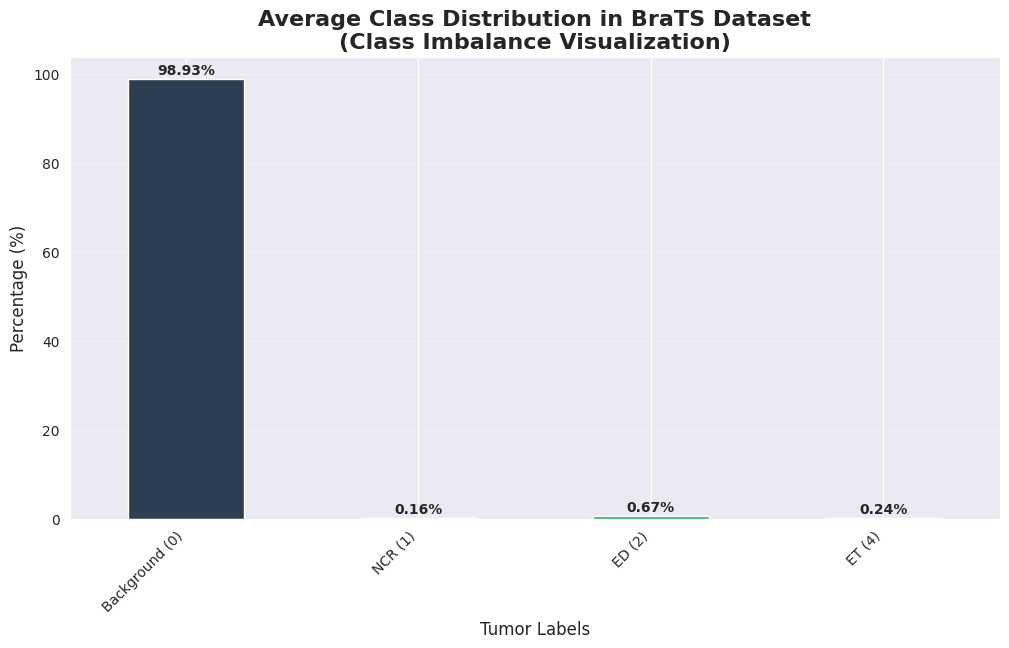

In [18]:
# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = 'white'

# --- Visualization 1: Bar Chart - Average Label Distribution ---
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#2C3E50', '#E74C3C', '#27AE60', '#F39C12']  # Background, NCR, ED, ET
avg_distribution.plot(kind='bar', ax=ax, color=colors)
ax.set_title('Average Class Distribution in BraTS Dataset\n(Class Imbalance Visualization)', 
             fontsize=16, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('Tumor Labels', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add percentage values on bars
for i, v in enumerate(avg_distribution):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

plt.show()

## isualization 2: Pie Chart - Tumor vs Background

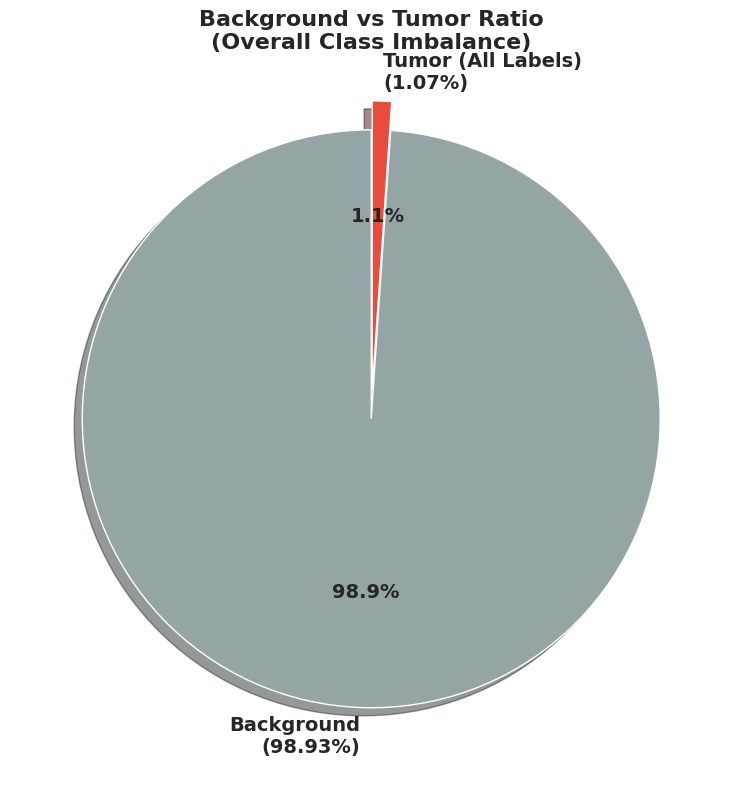

In [ ]:


fig, ax = plt.subplots(figsize=(10, 8))
tumor_percent = tumor_percentage
background_percent = avg_distribution['Background (0)']

sizes = [background_percent, tumor_percent]
labels = [f'Background\n({background_percent:.2f}%)', 
          f'Tumor (All Labels)\n({tumor_percent:.2f}%)']
colors_pie = ['#95A5A6', '#E74C3C']
explode = (0, 0.1)  # Explode tumor slice

ax.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'})
ax.set_title('Background vs Tumor Ratio\n(Overall Class Imbalance)', 
             fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Visualization 3: Tumor Volume Distribution 

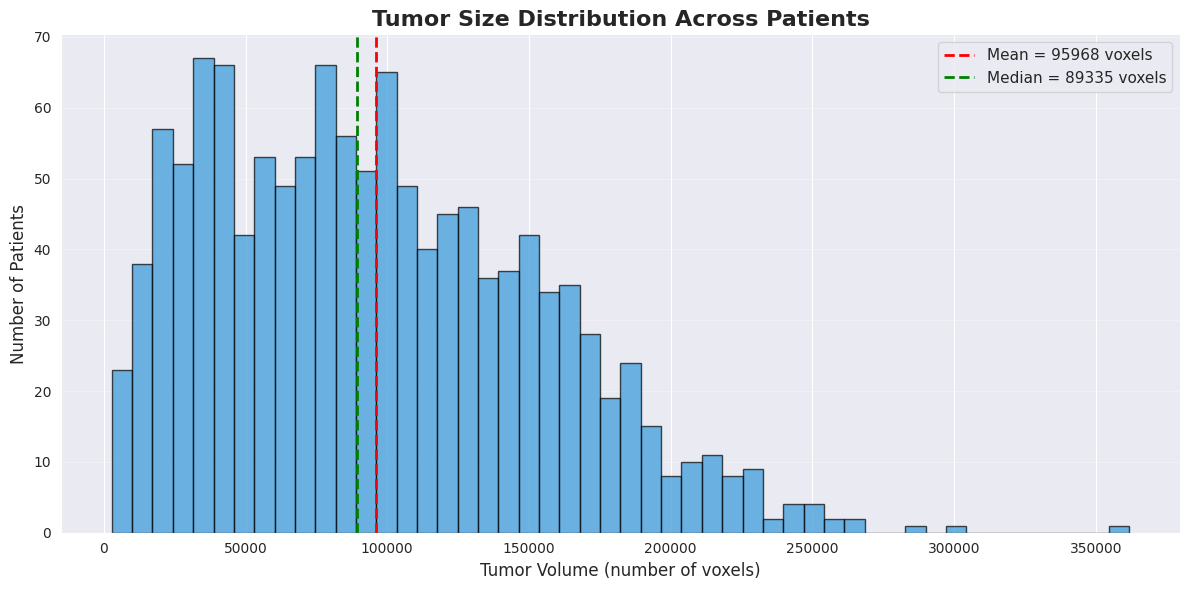

In [ ]:

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(tumor_volumes, bins=50, color='#3498DB', edgecolor='black', alpha=0.7)
ax.axvline(np.mean(tumor_volumes), color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {np.mean(tumor_volumes):.0f} voxels')
ax.axvline(np.median(tumor_volumes), color='green', linestyle='--', linewidth=2,
           label=f'Median = {np.median(tumor_volumes):.0f} voxels')
ax.set_xlabel('Tumor Volume (number of voxels)', fontsize=12)
ax.set_ylabel('Number of Patients', fontsize=12)
ax.set_title('Tumor Size Distribution Across Patients', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 4: Per-Patient Label Distribution (Heatmap for first 20)

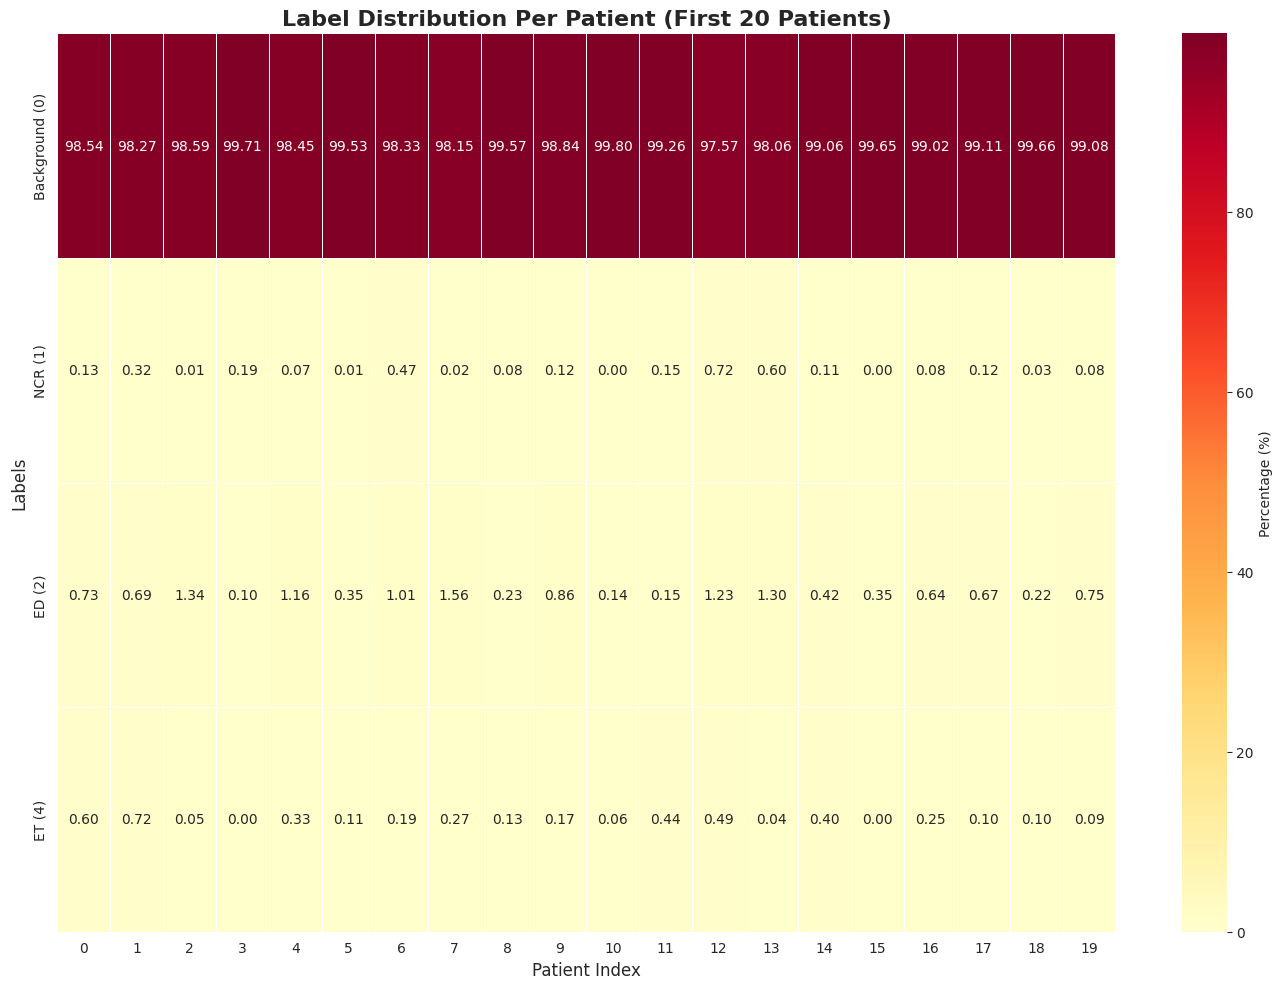

In [ ]:

if len(df_distributions) >= 20:
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Select first 20 patients
    heatmap_data = df_distributions.head(20)[['Background (0)', 'NCR (1)', 'ED (2)', 'ET (4)']]
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Percentage (%)'}, ax=ax, linewidths=0.5)
    ax.set_title('Label Distribution Per Patient (First 20 Patients)', 
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Patient Index', fontsize=12)
    ax.set_ylabel('Labels', fontsize=12)
    
    plt.tight_layout()
    plt.show()


## STEP 4: Tumor Volume Statistics

In [ ]:

print("\n" + "="*60)
print("📊 STEP 4: Tumor Volume Statistics")
print("="*60)

tumor_stats = {
    'Mean': np.mean(tumor_volumes),
    'Median': np.median(tumor_volumes),
    'Std Dev': np.std(tumor_volumes),
    'Min': np.min(tumor_volumes),
    'Max': np.max(tumor_volumes),
    'Q1 (25%)': np.percentile(tumor_volumes, 25),
    'Q3 (75%)': np.percentile(tumor_volumes, 75)
}

print("\nTumor Volume Statistics (in voxels):")
print("-" * 40)
for stat, value in tumor_stats.items():
    print(f"  {stat:12s}: {value:12,.0f}")
print("-" * 40)


📊 STEP 4: Tumor Volume Statistics

Tumor Volume Statistics (in voxels):
----------------------------------------
  Mean        :       95,968
  Median      :       89,335
  Std Dev     :       57,295
  Min         :        2,808
  Max         :      361,783
  Q1 (25%)    :       48,262
  Q3 (75%)    :      136,700
----------------------------------------


## STEP 5: Summary Report

In [ ]:

print("\n" + "="*60)
print("📋 FINAL SUMMARY REPORT")
print("="*60)

report = f"""
🧠 BraTS Dataset Analysis Summary
{'='*60}

1. DATASET OVERVIEW:
   - Total Patients: {len(df_summary)}
   - Complete Patients: {df_summary['is_complete'].sum()}
   - Incomplete Patients: {len(incomplete_patients)}

2. CLASS IMBALANCE (Critical Finding!):
   - Background: {avg_distribution['Background (0)']:.3f}%
   - NCR (Necrotic Core): {avg_distribution['NCR (1)']:.3f}%
   - ED (Edema): {avg_distribution['ED (2)']:.3f}%
   - ET (Enhancing Tumor): {avg_distribution['ET (4)']:.3f}%
   
   ⚠️ IMBALANCE RATIO: {imbalance_ratio:.2f}:1 (Background:Tumor)
   
3. TUMOR VOLUME STATISTICS:
   - Mean: {tumor_stats['Mean']:,.0f} voxels
   - Median: {tumor_stats['Median']:,.0f} voxels
   - Range: [{tumor_stats['Min']:,.0f} - {tumor_stats['Max']:,.0f}]

4. RECOMMENDED ACTIONS FOR IMBALANCE:
   ✓ Use Dice Loss + Weighted Cross-Entropy
   ✓ Implement patch-based training (focus on tumor regions)
   ✓ Apply class weights: ~[0.1, 1.0, 1.0, 1.0]
   ✓ Use data augmentation on tumor patches
   ✓ Consider focal loss for hard examples

5. OUTPUT FILES GENERATED:
   ✓ dataset_summary.csv
   ✓ label_distributions.csv
   ✓ class_distribution.png
   ✓ background_vs_tumor.png
   ✓ tumor_volumes.png
   ✓ per_patient_heatmap.png (if ≥20 patients)

{'='*60}
"""

print(report)



print("\n" + "="*60)
print("✅ ANALYSIS COMPLETE!")
print("="*60)
print(f"\nAll outputs saved to: {OUTPUT_DIR}")
print("\nNext Steps:")
print("  1. Review the visualizations")
print("  2. Plan your preprocessing pipeline")
print("  3. Design loss function to handle imbalance")
print("  4. Start patch extraction for training")


📋 FINAL SUMMARY REPORT

🧠 BraTS Dataset Analysis Summary

1. DATASET OVERVIEW:
   - Total Patients: 1251
   - Complete Patients: 1251
   - Incomplete Patients: 0

2. CLASS IMBALANCE (Critical Finding!):
   - Background: 98.925%
   - NCR (Necrotic Core): 0.160%
   - ED (Edema): 0.674%
   - ET (Enhancing Tumor): 0.240%
   
   ⚠️ IMBALANCE RATIO: 92.03:1 (Background:Tumor)
   
3. TUMOR VOLUME STATISTICS:
   - Mean: 95,968 voxels
   - Median: 89,335 voxels
   - Range: [2,808 - 361,783]

4. RECOMMENDED ACTIONS FOR IMBALANCE:
   ✓ Use Dice Loss + Weighted Cross-Entropy
   ✓ Implement patch-based training (focus on tumor regions)
   ✓ Apply class weights: ~[0.1, 1.0, 1.0, 1.0]
   ✓ Use data augmentation on tumor patches
   ✓ Consider focal loss for hard examples

5. OUTPUT FILES GENERATED:
   ✓ dataset_summary.csv
   ✓ label_distributions.csv
   ✓ class_distribution.png
   ✓ background_vs_tumor.png
   ✓ tumor_volumes.png
   ✓ per_patient_heatmap.png (if ≥20 patients)



✅ ANALYSIS COMPLETE!


##  COMPREHENSIVE DATA QUALITY CHECK

🔍 COMPREHENSIVE DATA QUALITY CHECK

📂 Found 1251 patients to analyze

🔬 ISSUE 1: Checking for Intensity Anomalies

⏳ Analyzing intensity distributions...


100%|██████████| 50/50 [01:16<00:00,  1.52s/it]



⚠️ Found 15 intensity-related issues

Top Issues:
        patient_id modality              issue            details
0  BraTS2021_01030       t2  EXTREME_INTENSITY  Max value = 30347
1  BraTS2021_00466     t1ce  EXTREME_INTENSITY  Max value = 13624
2  BraTS2021_01640     t1ce  EXTREME_INTENSITY  Max value = 13446
3  BraTS2021_00098     t1ce  EXTREME_INTENSITY  Max value = 15610
4  BraTS2021_00469     t1ce  EXTREME_INTENSITY  Max value = 14660
5  BraTS2021_00021     t1ce  EXTREME_INTENSITY  Max value = 12138
6  BraTS2021_01554     t1ce  EXTREME_INTENSITY  Max value = 14473
7  BraTS2021_00602     t1ce  EXTREME_INTENSITY  Max value = 12949
8  BraTS2021_00774     t1ce  EXTREME_INTENSITY  Max value = 11939
9  BraTS2021_00593     t1ce  EXTREME_INTENSITY  Max value = 10184


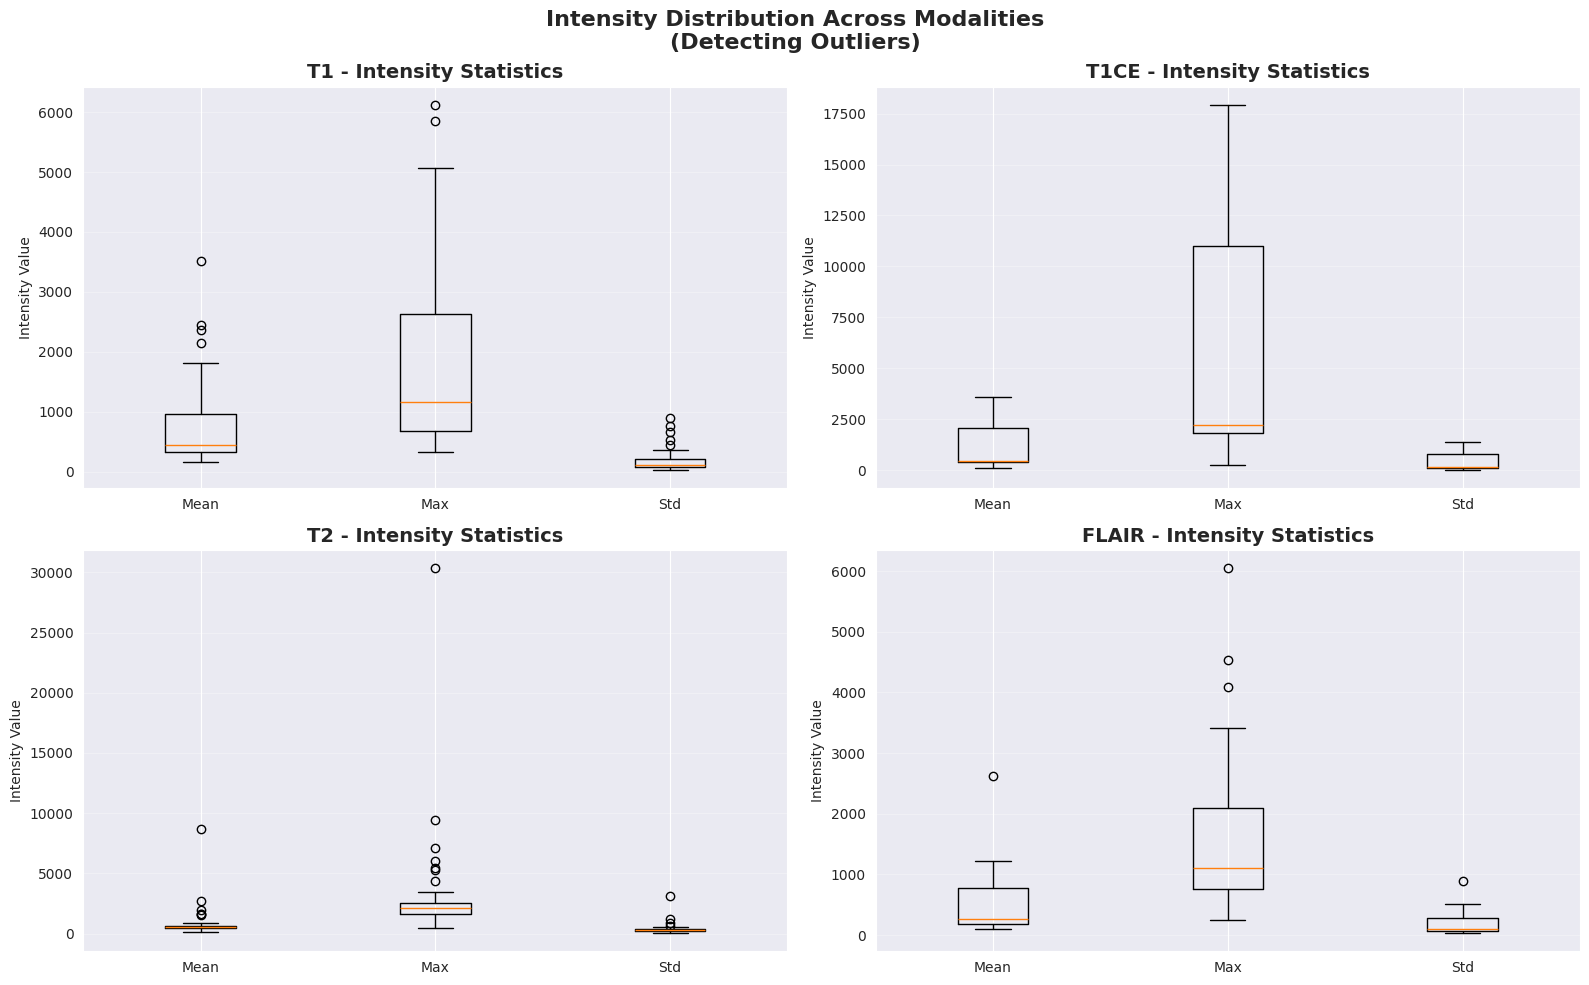

✅ Displayed: Intensity Statistics Boxplot

📐 ISSUE 2: Checking Shape & Voxel Spacing Consistency

⏳ Analyzing image dimensions...


100%|██████████| 1251/1251 [01:00<00:00, 20.83it/s]



⚠️ Found 0 shape/spacing issues

📊 Shape Distribution:
shape
(240, 240, 155)    1251
Name: count, dtype: int64

🎯 ISSUE 3: Checking Tumor Annotation Quality

⏳ Analyzing tumor annotations...


100%|██████████| 1251/1251 [05:56<00:00,  3.51it/s]



⚠️ Found 0 tumor annotation issues


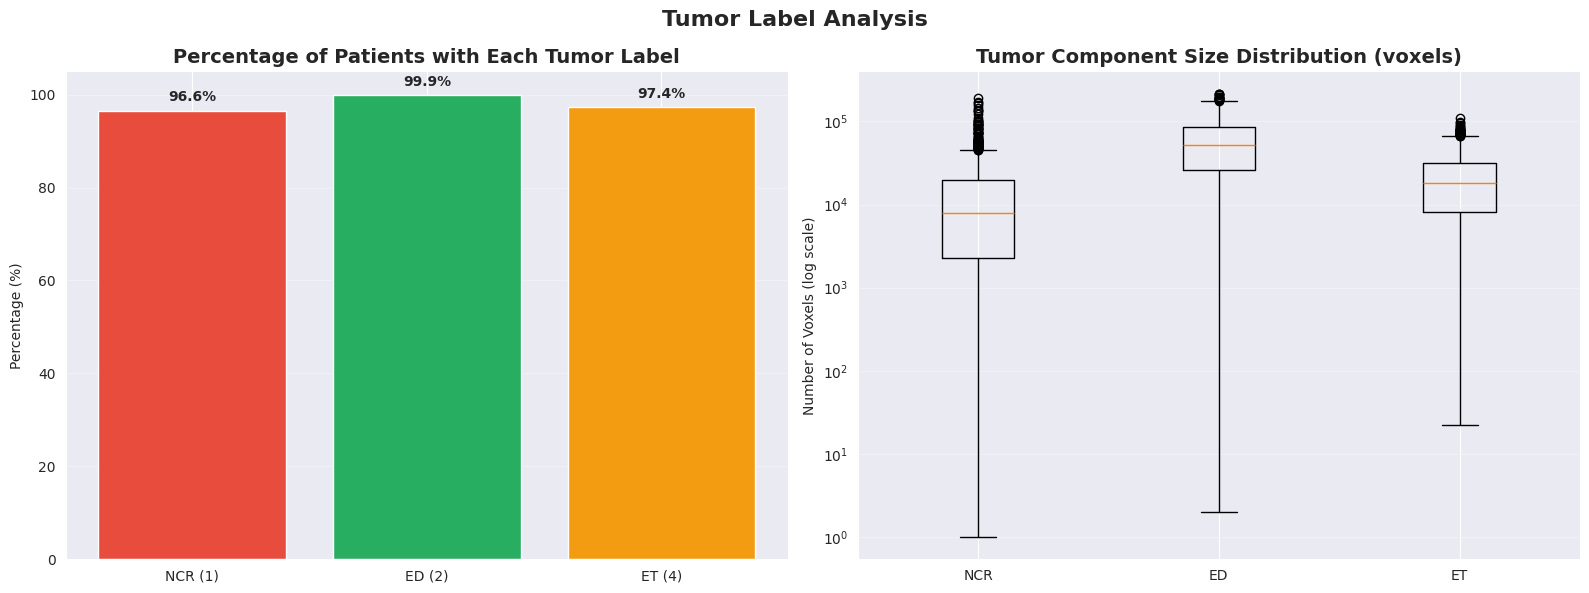

✅ Displayed: Tumor Label Analysis

💥 ISSUE 4: Testing File Integrity

⏳ Testing file readability...


100%|██████████| 1251/1251 [20:08<00:00,  1.03it/s]



⚠️ Found 0 file integrity issues

🔗 ISSUE 5: Checking Co-registration Quality

⏳ Checking alignment between modalities...


100%|██████████| 30/30 [00:07<00:00,  4.24it/s]


⚠️ Found 0 potential co-registration issues

📋 COMPREHENSIVE QUALITY CHECK SUMMARY

🔍 DATA QUALITY ASSESSMENT REPORT

📊 ANALYSIS SCOPE:
   - Total Patients Scanned: 1251
   - Detailed Analysis: ~50 patients (for speed)

⚠️ ISSUES DETECTED:
   
   1. INTENSITY ANOMALIES: 15 issues
      • Blank scans, extreme values, low variance
      
   2. SHAPE/SPACING PROBLEMS: 0 issues
      • Shape mismatches between modalities
      • Inconsistent voxel spacing
      
   3. TUMOR ANNOTATION ISSUES: 0 issues
      • Empty annotations, tiny tumors, unexpected labels
      
   4. FILE INTEGRITY PROBLEMS: 0 issues
      • Corrupted files, missing files, unreadable data
      
   5. CO-REGISTRATION ISSUES: 0 issues
      • Poor alignment between modalities and segmentation

📈 TOTAL ISSUES FOUND: 15

🎯 RECOMMENDATIONS:

   ✓ Apply robust normalization (Z-score with outlier clipping)

💾 NEXT STEPS:
   1. Review detailed issue DataFrames
   2. Clean/filter problematic cases
   3. Implement robust prepr

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===== Configuration =====
DATA_PATH = '/kaggle/input/brain-tumor-segmentation-hackathon'
OUTPUT_DIR = '/kaggle/working'


def find_nii_file(patient_dir, modality):
    """Find .nii file even if nested in subfolders"""
    direct_file = os.path.join(patient_dir, f'{os.path.basename(patient_dir)}_{modality}.nii')
    if os.path.isfile(direct_file):
        return direct_file
    
    folder_path = os.path.join(patient_dir, f'{os.path.basename(patient_dir)}_{modality}.nii')
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                return os.path.join(folder_path, file)
    
    patient_name = os.path.basename(patient_dir)
    for root, dirs, files in os.walk(patient_dir):
        for file in files:
            if modality in file.lower() and (file.endswith('.nii') or file.endswith('.nii.gz')):
                return os.path.join(root, file)
    
    return None

def get_patient_files(patient_dir):
    """Get all patient files"""
    files = {}
    modalities = ['t1', 't1ce', 't2', 'flair', 'seg']
    for mod in modalities:
        file_path = find_nii_file(patient_dir, mod)
        files[mod] = file_path
    return files

# ===== Get Patient List =====
print("="*70)
print("🔍 COMPREHENSIVE DATA QUALITY CHECK")
print("="*70)

all_items = os.listdir(DATA_PATH)
patient_dirs = [os.path.join(DATA_PATH, item) for item in all_items 
                if os.path.isdir(os.path.join(DATA_PATH, item)) and item.startswith('BraTS')]

print(f"\n📂 Found {len(patient_dirs)} patients to analyze")

# ===== ISSUE 1: Intensity Anomalies =====
print("\n" + "="*70)
print("🔬 ISSUE 1: Checking for Intensity Anomalies")
print("="*70)

intensity_issues = []
intensity_stats = []

print("\n⏳ Analyzing intensity distributions...")
for patient_dir in tqdm(patient_dirs[:50]): 
    patient_id = os.path.basename(patient_dir)
    files = get_patient_files(patient_dir)
    
    if not all(files.values()):
        continue
    
    try:
        for mod in ['t1', 't1ce', 't2', 'flair']:
            img = nib.load(files[mod]).get_fdata()
            
           
            brain_voxels = img[img > 0]
            
            if len(brain_voxels) == 0:
                intensity_issues.append({
                    'patient_id': patient_id,
                    'modality': mod,
                    'issue': 'BLANK_SCAN',
                    'details': 'All voxels are zero'
                })
                continue
            
            stats = {
                'patient_id': patient_id,
                'modality': mod,
                'mean': brain_voxels.mean(),
                'std': brain_voxels.std(),
                'min': brain_voxels.min(),
                'max': brain_voxels.max(),
                'median': np.median(brain_voxels),
                'q95': np.percentile(brain_voxels, 95)
            }
            intensity_stats.append(stats)
            
           
            if brain_voxels.max() > 10000:
                intensity_issues.append({
                    'patient_id': patient_id,
                    'modality': mod,
                    'issue': 'EXTREME_INTENSITY',
                    'details': f'Max value = {brain_voxels.max():.0f}'
                })
            
            if brain_voxels.std() < 1:
                intensity_issues.append({
                    'patient_id': patient_id,
                    'modality': mod,
                    'issue': 'LOW_VARIANCE',
                    'details': f'Std = {brain_voxels.std():.2f}'
                })
                
    except Exception as e:
        intensity_issues.append({
            'patient_id': patient_id,
            'modality': 'ALL',
            'issue': 'LOAD_ERROR',
            'details': str(e)
        })

df_intensity_stats = pd.DataFrame(intensity_stats)
df_intensity_issues = pd.DataFrame(intensity_issues)

print(f"\n⚠️ Found {len(df_intensity_issues)} intensity-related issues")
if len(df_intensity_issues) > 0:
    print("\nTop Issues:")
    print(df_intensity_issues.head(10))

# Visualization: Intensity Range per Modality
if len(df_intensity_stats) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    modalities = ['t1', 't1ce', 't2', 'flair']
    
    for idx, mod in enumerate(modalities):
        ax = axes[idx//2, idx%2]
        mod_data = df_intensity_stats[df_intensity_stats['modality'] == mod]
        
        if len(mod_data) > 0:
            ax.boxplot([mod_data['mean'], mod_data['max'], mod_data['std']], 
                      labels=['Mean', 'Max', 'Std'])
            ax.set_title(f'{mod.upper()} - Intensity Statistics', fontsize=14, fontweight='bold')
            ax.set_ylabel('Intensity Value')
            ax.grid(axis='y', alpha=0.3)
    
    plt.suptitle('Intensity Distribution Across Modalities\n(Detecting Outliers)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✅ Displayed: Intensity Statistics Boxplot")

# ===== ISSUE 2: Shape & Spacing Inconsistencies =====
print("\n" + "="*70)
print("📐 ISSUE 2: Checking Shape & Voxel Spacing Consistency")
print("="*70)

shape_issues = []
spacing_info = []

print("\n⏳ Analyzing image dimensions...")
for patient_dir in tqdm(patient_dirs):
    patient_id = os.path.basename(patient_dir)
    files = get_patient_files(patient_dir)
    
    if not all(files.values()):
        continue
    
    try:
      
        shapes = {}
        spacings = {}
        
        for mod in ['t1', 't1ce', 't2', 'flair', 'seg']:
            img_nii = nib.load(files[mod])
            shapes[mod] = img_nii.shape
            spacings[mod] = img_nii.header.get_zooms()
        
       
        unique_shapes = set([tuple(s) for s in shapes.values()])
        if len(unique_shapes) > 1:
            shape_issues.append({
                'patient_id': patient_id,
                'issue': 'SHAPE_MISMATCH',
                'details': f'Different shapes: {shapes}'
            })
        
       
        spacing_info.append({
            'patient_id': patient_id,
            'shape': shapes['t1'],
            'spacing': spacings['t1']
        })
        
        
        unique_spacings = set([tuple(s) for s in spacings.values()])
        if len(unique_spacings) > 1:
            shape_issues.append({
                'patient_id': patient_id,
                'issue': 'SPACING_MISMATCH',
                'details': f'Different voxel spacings between modalities'
            })
            
    except Exception as e:
        shape_issues.append({
            'patient_id': patient_id,
            'issue': 'PROCESSING_ERROR',
            'details': str(e)
        })

df_shape_issues = pd.DataFrame(shape_issues)
df_spacing = pd.DataFrame(spacing_info)

print(f"\n⚠️ Found {len(df_shape_issues)} shape/spacing issues")
if len(df_shape_issues) > 0:
    print("\nIssues Found:")
    print(df_shape_issues.head())

# Check for non-standard shapes
if len(df_spacing) > 0:
    print("\n📊 Shape Distribution:")
    shape_counts = df_spacing['shape'].value_counts()
    print(shape_counts)
    
    if len(shape_counts) > 1:
        print("\n⚠️ WARNING: Multiple different shapes detected!")
        print("   This might require resizing/resampling during preprocessing")

# ===== ISSUE 3: Missing/Empty Tumor Annotations =====
print("\n" + "="*70)
print("🎯 ISSUE 3: Checking Tumor Annotation Quality")
print("="*70)

tumor_issues = []
tumor_label_stats = []

print("\n⏳ Analyzing tumor annotations...")
for patient_dir in tqdm(patient_dirs):
    patient_id = os.path.basename(patient_dir)
    files = get_patient_files(patient_dir)
    
    if files['seg'] is None:
        continue
    
    try:
        seg = nib.load(files['seg']).get_fdata()
        
       
        ncr_count = np.sum(seg == 1)
        ed_count = np.sum(seg == 2)
        et_count = np.sum(seg == 4)
        total_tumor = ncr_count + ed_count + et_count
        
        tumor_label_stats.append({
            'patient_id': patient_id,
            'ncr_voxels': ncr_count,
            'ed_voxels': ed_count,
            'et_voxels': et_count,
            'total_tumor_voxels': total_tumor,
            'has_ncr': ncr_count > 0,
            'has_ed': ed_count > 0,
            'has_et': et_count > 0
        })
        
      
        if total_tumor == 0:
            tumor_issues.append({
                'patient_id': patient_id,
                'issue': 'NO_TUMOR',
                'details': 'Segmentation mask is completely empty'
            })
        
        if total_tumor < 100:  
            tumor_issues.append({
                'patient_id': patient_id,
                'issue': 'TINY_TUMOR',
                'details': f'Only {total_tumor} tumor voxels'
            })
        
       
        unique_labels = np.unique(seg)
        expected_labels = {0, 1, 2, 4}
        unexpected = set(unique_labels) - expected_labels
        
        if unexpected:
            tumor_issues.append({
                'patient_id': patient_id,
                'issue': 'UNEXPECTED_LABELS',
                'details': f'Found labels: {unexpected}'
            })
            
    except Exception as e:
        tumor_issues.append({
            'patient_id': patient_id,
            'issue': 'LOAD_ERROR',
            'details': str(e)
        })

df_tumor_stats = pd.DataFrame(tumor_label_stats)
df_tumor_issues = pd.DataFrame(tumor_issues)

print(f"\n⚠️ Found {len(df_tumor_issues)} tumor annotation issues")
if len(df_tumor_issues) > 0:
    print("\nIssues Found:")
    print(df_tumor_issues.head(10))

# Visualization: Label Presence Distribution
if len(df_tumor_stats) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Subplot 1: Percentage of patients with each label
    label_presence = {
        'NCR (1)': (df_tumor_stats['has_ncr'].sum() / len(df_tumor_stats)) * 100,
        'ED (2)': (df_tumor_stats['has_ed'].sum() / len(df_tumor_stats)) * 100,
        'ET (4)': (df_tumor_stats['has_et'].sum() / len(df_tumor_stats)) * 100
    }
    
    axes[0].bar(label_presence.keys(), label_presence.values(), 
                color=['#E74C3C', '#27AE60', '#F39C12'])
    axes[0].set_title('Percentage of Patients with Each Tumor Label', 
                     fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_ylim([0, 105])
    axes[0].grid(axis='y', alpha=0.3)
    
    for i, (label, val) in enumerate(label_presence.items()):
        axes[0].text(i, val + 2, f'{val:.1f}%', ha='center', fontweight='bold')
    
    # Subplot 2: Tumor size distribution per label
    axes[1].boxplot([
        df_tumor_stats[df_tumor_stats['ncr_voxels'] > 0]['ncr_voxels'],
        df_tumor_stats[df_tumor_stats['ed_voxels'] > 0]['ed_voxels'],
        df_tumor_stats[df_tumor_stats['et_voxels'] > 0]['et_voxels']
    ], labels=['NCR', 'ED', 'ET'])
    axes[1].set_title('Tumor Component Size Distribution (voxels)', 
                     fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Number of Voxels (log scale)')
    axes[1].set_yscale('log')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.suptitle('Tumor Label Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    print("✅ Displayed: Tumor Label Analysis")

# ===== ISSUE 4: Corrupted or Unreadable Files =====
print("\n" + "="*70)
print("💥 ISSUE 4: Testing File Integrity")
print("="*70)

corrupted_files = []

print("\n⏳ Testing file readability...")
for patient_dir in tqdm(patient_dirs):
    patient_id = os.path.basename(patient_dir)
    files = get_patient_files(patient_dir)
    
    for mod, filepath in files.items():
        if filepath is None:
            corrupted_files.append({
                'patient_id': patient_id,
                'modality': mod,
                'issue': 'FILE_NOT_FOUND',
                'filepath': 'N/A'
            })
            continue
        
        try:
           
            img_nii = nib.load(filepath)
            data = img_nii.get_fdata()
            
            
            if data.size == 0:
                corrupted_files.append({
                    'patient_id': patient_id,
                    'modality': mod,
                    'issue': 'EMPTY_DATA',
                    'filepath': filepath
                })
                
        except Exception as e:
            corrupted_files.append({
                'patient_id': patient_id,
                'modality': mod,
                'issue': 'CORRUPTED_FILE',
                'filepath': filepath,
                'error': str(e)
            })

df_corrupted = pd.DataFrame(corrupted_files)

print(f"\n⚠️ Found {len(df_corrupted)} file integrity issues")
if len(df_corrupted) > 0:
    print("\nCorrupted/Missing Files:")
    print(df_corrupted.head(15))

# ===== ISSUE 5: Co-registration Check =====
print("\n" + "="*70)
print("🔗 ISSUE 5: Checking Co-registration Quality")
print("="*70)

coregistration_issues = []

print("\n⏳ Checking alignment between modalities...")
for patient_dir in tqdm(patient_dirs[:30]): 
    patient_id = os.path.basename(patient_dir)
    files = get_patient_files(patient_dir)
    
    if not all(files.values()):
        continue
    
    try:
        # Load all modalities
        t1 = nib.load(files['t1']).get_fdata()
        seg = nib.load(files['seg']).get_fdata()
        
        
        tumor_mask = seg > 0
        brain_mask = t1 > 0
        
       
        overlap = np.sum(tumor_mask & brain_mask) / np.sum(tumor_mask) if np.sum(tumor_mask) > 0 else 0
        
        if overlap < 0.8:  
            coregistration_issues.append({
                'patient_id': patient_id,
                'issue': 'POOR_ALIGNMENT',
                'overlap_percentage': overlap * 100,
                'details': 'Tumor mask doesn\'t align well with brain tissue'
            })
            
    except Exception as e:
        continue

df_coreg_issues = pd.DataFrame(coregistration_issues)

print(f"\n⚠️ Found {len(df_coreg_issues)} potential co-registration issues")
if len(df_coreg_issues) > 0:
    print("\nAlignment Issues:")
    print(df_coreg_issues)

# ===== FINAL SUMMARY REPORT =====
print("\n" + "="*70)
print("📋 COMPREHENSIVE QUALITY CHECK SUMMARY")
print("="*70)

total_issues = (len(df_intensity_issues) + len(df_shape_issues) + 
                len(df_tumor_issues) + len(df_corrupted) + len(df_coreg_issues))

summary_report = f"""
🔍 DATA QUALITY ASSESSMENT REPORT
{'='*70}

📊 ANALYSIS SCOPE:
   - Total Patients Scanned: {len(patient_dirs)}
   - Detailed Analysis: ~50 patients (for speed)

⚠️ ISSUES DETECTED:
   
   1. INTENSITY ANOMALIES: {len(df_intensity_issues)} issues
      • Blank scans, extreme values, low variance
      
   2. SHAPE/SPACING PROBLEMS: {len(df_shape_issues)} issues
      • Shape mismatches between modalities
      • Inconsistent voxel spacing
      
   3. TUMOR ANNOTATION ISSUES: {len(df_tumor_issues)} issues
      • Empty annotations, tiny tumors, unexpected labels
      
   4. FILE INTEGRITY PROBLEMS: {len(df_corrupted)} issues
      • Corrupted files, missing files, unreadable data
      
   5. CO-REGISTRATION ISSUES: {len(df_coreg_issues)} issues
      • Poor alignment between modalities and segmentation

📈 TOTAL ISSUES FOUND: {total_issues}

🎯 RECOMMENDATIONS:
"""

if len(df_corrupted) > 0:
    summary_report += "\n   ⚠️ CRITICAL: Remove corrupted files before training!"

if len(df_shape_issues) > 0:
    summary_report += "\n   ⚠️ IMPORTANT: Implement resampling/resizing in preprocessing"

if len(df_intensity_issues) > 0:
    summary_report += "\n   ✓ Apply robust normalization (Z-score with outlier clipping)"

if len(df_tumor_issues) > 0:
    summary_report += "\n   ✓ Consider filtering out empty/tiny tumor cases"
    summary_report += "\n   ✓ Verify label integrity before training"

summary_report += f"""

💾 NEXT STEPS:
   1. Review detailed issue DataFrames
   2. Clean/filter problematic cases
   3. Implement robust preprocessing pipeline
   4. Add data validation in training loop

{'='*70}
"""

print(summary_report)

# Display issues instead of saving
if len(df_intensity_issues) > 0:
    print("\n📊 Intensity Issues Found:")
    print(df_intensity_issues)
else:
    print("\n✅ No intensity issues found!")

if len(df_shape_issues) > 0:
    print("\n📊 Shape/Spacing Issues Found:")
    print(df_shape_issues)
else:
    print("\n✅ No shape/spacing issues found!")

if len(df_tumor_issues) > 0:
    print("\n📊 Tumor Annotation Issues Found:")
    print(df_tumor_issues)
else:
    print("\n✅ No tumor annotation issues found!")

if len(df_corrupted) > 0:
    print("\n📊 Corrupted/Missing Files Found:")
    print(df_corrupted)
else:
    print("\n✅ No corrupted files found!")

# Display co-registration issues if any
if len(df_coreg_issues) > 0:
    print("\n📊 Co-registration Issues Found:")
    print(df_coreg_issues)
else:
    print("\n✅ No co-registration issues found!")

print("\n" + "="*70)
print("✅ QUALITY CHECK COMPLETE!")
print("="*70)
print("\n💡 Review the issues displayed above to plan your preprocessing pipeline")

# **After Train**

# **Comparison between AI and Ground Truth**

**2D**

✅ Model weights loaded successfully.
🔄 Processing BraTS2021_00715...


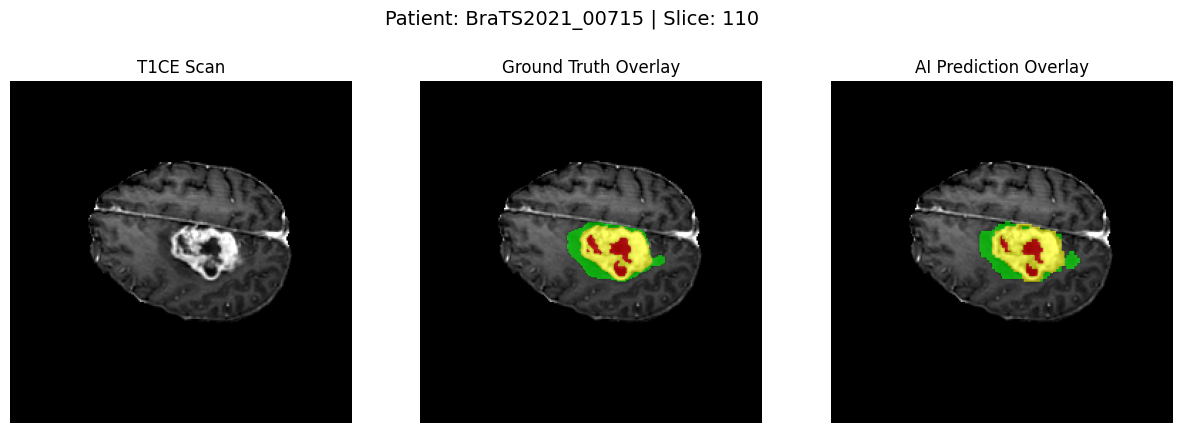

🔄 Processing BraTS2021_00646...


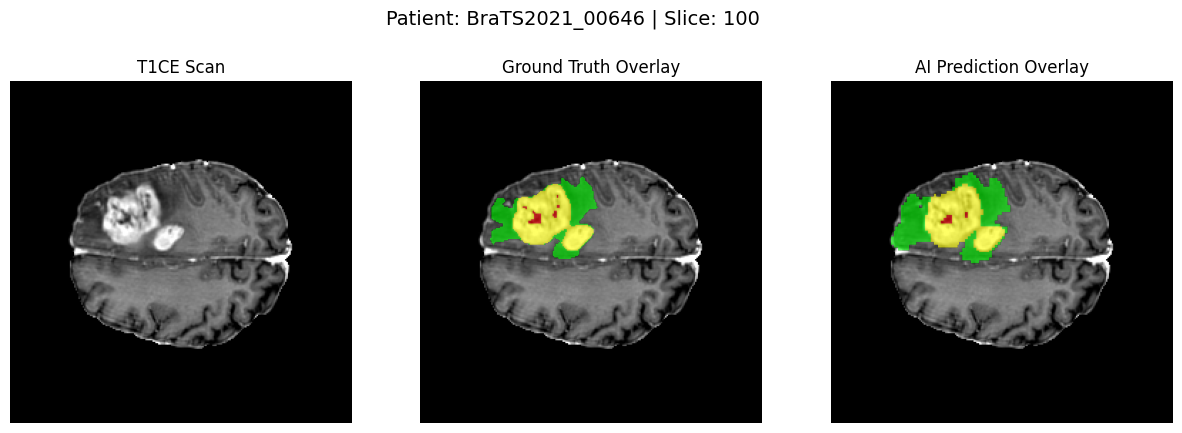

In [ ]:
import os
import random
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from skimage import measure
from tqdm import tqdm


Config = {
    "IMG_SIZE": 128,
    "DEVICE": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "WEIGHTS_PATH": "/kaggle/input/bestmodel2/brats_75slices_best (5).pth", 
    "TEST_DIR": "/kaggle/input/brain-tumor-segmentation-hackathon",
    "NUM_SAMPLES": 2  
}


def find_nii_path(parent_dir, naming_pattern):
   
    for root, dirs, files in os.walk(parent_dir):
        for f in files:
            if naming_pattern in f and (f.endswith('.nii') or f.endswith('.nii.gz')):
                if naming_pattern == 't1' and 't1ce' in f: continue
                full_path = os.path.join(root, f)
                if os.path.getsize(full_path) > 0:
                    return full_path
    return None

def load_3d_volume(patient_path, modality_type):
    path = find_nii_path(patient_path, modality_type)
    if not path: return None
    try:
        data = nib.load(path).get_fdata()
        return np.asanyarray(data)
    except: return None

def brats_normalize(img):
   
    img = img.astype(np.float32)
    mask = img > 0
    if mask.sum() == 0: return img
    p1, p99 = np.percentile(img[mask], (1, 99))
    img = np.clip(img, p1, p99)
    return (img - p1) / (p99 - p1 + 1e-6)

# ========================================================
# 3. Model Architecture (ResUNet2D)
# ========================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c)
        )
        self.short = nn.Sequential(nn.Conv2d(in_c, out_c, 1), nn.BatchNorm2d(out_c)) if in_c != out_c else nn.Identity()
    def forward(self, x): return F.relu(self.conv(x) + self.short(x))

class ResUNet2D(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.e1 = ResidualBlock(4, 32); self.e2 = ResidualBlock(32, 64); self.e3 = ResidualBlock(64, 128); self.bot = ResidualBlock(128, 256)
        self.d3 = ResidualBlock(256 + 128, 128); self.d2 = ResidualBlock(128 + 64, 64); self.d1 = ResidualBlock(64 + 32, 32)
        self.final = nn.Conv2d(32, n_classes, 1)
        self.pool = nn.MaxPool2d(2); self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, x):
        x1 = self.e1(x); x2 = self.e2(self.pool(x1)); x3 = self.e3(self.pool(x2)); b = self.bot(self.pool(x3))
        x = self.d3(torch.cat([self.up(b), x3], 1)); x = self.d2(torch.cat([self.up(x), x2], 1)); x = self.d1(torch.cat([self.up(x), x1], 1))
        return self.final(x)

# ========================================================
# 4. Visualization Core (Fixed Mapping)
# ========================================================
def visualize_all(gt_vol, pred_vol, mods_data, pid):
   
    tumor_indices = np.where(np.any(gt_vol > 0, axis=(0, 1)))[0]
    if len(tumor_indices) == 0: return
    s_idx = tumor_indices[len(tumor_indices)//2]

    
    from matplotlib.colors import ListedColormap
    my_cmap = ListedColormap([(0,0,0,0), (1,0,0,0.6), (0,1,0,0.6), (1,1,0,0.6)])
    
    
    t1ce_2d = brats_normalize(mods_data['t1ce'][:,:,s_idx])
    gt_2d = gt_vol[:,:,s_idx].copy()
    gt_2d[gt_2d == 4] = 3 
    pred_2d = pred_vol[:,:,s_idx].copy()
    pred_2d[pred_2d == 4] = 3

    
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"Patient: {pid} | Slice: {s_idx}", fontsize=14)
    titles = ["T1CE Scan", "Ground Truth Overlay", "AI Prediction Overlay"]
    imgs = [t1ce_2d, gt_2d, pred_2d]
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.imshow(t1ce_2d, cmap='gray')
        if i > 0: plt.imshow(imgs[i], cmap=my_cmap)
        plt.title(titles[i]); plt.axis('off')
    plt.show()

# ========================================================
# 5. Prediction & Run
# ========================================================
def run_full_analysis():
    
    model = ResUNet2D(n_classes=4).to(Config['DEVICE'])
    if os.path.exists(Config['WEIGHTS_PATH']):
        ckpt = torch.load(Config['WEIGHTS_PATH'], map_location=Config['DEVICE'])
        model.load_state_dict(ckpt['model_state_dict'] if 'model_state_dict' in ckpt else ckpt)
        print("✅ Model weights loaded successfully.")
    

    all_p = sorted([d for d in os.listdir(Config['TEST_DIR']) if "BraTS2021_" in d])
    selected = random.sample(all_p, Config['NUM_SAMPLES'])

    for pid in selected:
        print(f"🔄 Processing {pid}...")
        p_path = os.path.join(Config['TEST_DIR'], pid)
        gt_vol = load_3d_volume(p_path, 'seg')
        mods = {m: load_3d_volume(p_path, m) for m in ['flair', 't1', 't1ce', 't2']}
        
        if gt_vol is None or mods['flair'] is None: 
            print(f"⚠️ Skipping {pid} (Missing Files)")
            continue

        
        D, H, W = gt_vol.shape[2], gt_vol.shape[0], gt_vol.shape[1]
        pred_3d = np.zeros_like(gt_vol)
        
        model.eval()
        with torch.no_grad():
            for z in range(D):
               
                slices = [cv2.resize(brats_normalize(mods[m][:,:,z]), (Config['IMG_SIZE'], Config['IMG_SIZE'])) for m in mods]
                x = torch.from_numpy(np.stack(slices)).unsqueeze(0).float().to(Config['DEVICE'])
                # Prediction
                out = torch.argmax(model(x), 1).squeeze().cpu().numpy()
                pred_3d[:,:,z] = cv2.resize(out.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

        
        visualize_all(gt_vol, pred_3d, mods, pid)


run_full_analysis()

**3D**

In [10]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import plotly.graph_objects as go
from skimage import measure

# ==========================================
# 1. Model Architecture (ResUNet2D)
# ==========================================
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c)
        )
        self.short = nn.Sequential(nn.Conv2d(in_c, out_c, 1), nn.BatchNorm2d(out_c)) if in_c != out_c else nn.Identity()
    def forward(self, x): return F.relu(self.conv(x) + self.short(x))

class ResUNet2D(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.e1 = ResidualBlock(4, 32); self.e2 = ResidualBlock(32, 64); self.e3 = ResidualBlock(64, 128); self.bot = ResidualBlock(128, 256)
        self.d3 = ResidualBlock(256 + 128, 128); self.d2 = ResidualBlock(128 + 64, 64); self.d1 = ResidualBlock(64 + 32, 32)
        self.final = nn.Conv2d(32, n_classes, 1)
        self.pool = nn.MaxPool2d(2); self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    def forward(self, x):
        x1 = self.e1(x); x2 = self.e2(self.pool(x1)); x3 = self.e3(self.pool(x2)); b = self.bot(self.pool(x3))
        x = self.d3(torch.cat([self.up(b), x3], 1)); x = self.d2(torch.cat([self.up(x), x2], 1)); x = self.d1(torch.cat([self.up(x), x1], 1))
        return self.final(x)

# ==========================================
# 2. Helpers (File Loading & Normalization)
# ==========================================
def get_valid_file_path(patient_dir, pid, modality):
    candidates = [f"{pid}_{modality}.nii", f"{pid}_{modality}.nii.gz", f"{modality}.nii", f"{modality}.nii.gz"]
    for f in candidates:
        full_path = os.path.join(patient_dir, f)
        if os.path.exists(full_path) and os.path.getsize(full_path) > 0: return full_path
    return None

def brats_normalize(volume):
    vol = volume.astype(np.float32)
    mask = vol > 0
    if mask.sum() == 0: return vol
    p1, p99 = np.percentile(vol[mask], (1, 99))
    vol = np.clip(vol, p1, p99)
    return (vol - p1) / (p99 - p1 + 1e-6)

# ==========================================
# 3. Visualization Logic (3D Plotly)
# ==========================================
def plot_brain_with_mask(t1_vol, mask_vol, title):
    print(f"🎨 Rendering 3D: {title} ...")
    data = []
    
    # 1. Brain Structure (Gray Shell)
    try:
        verts, faces, _, _ = measure.marching_cubes(t1_vol > 10, step_size=2)
        data.append(go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2], i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                              opacity=0.1, color='gray', name='Brain Structure', showlegend=True))
    except: pass

    # 2. Tumor Regions
    classes = {1: {'name': 'Necrotic (NCR)', 'color': 'red', 'opacity': 0.8},
               2: {'name': 'Edema (ED)', 'color': 'green', 'opacity': 0.3},
               4: {'name': 'Enhancing (ET)', 'color': 'gold', 'opacity': 0.8}}
    
    for c_id, props in classes.items():
        binary = (mask_vol == c_id)
        if np.sum(binary) > 10:
            try:
                verts, faces, _, _ = measure.marching_cubes(binary, level=0.5, step_size=1)
                data.append(go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2], i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                                      opacity=props['opacity'], color=props['color'], name=props['name'], showlegend=True))
            except: pass

    fig = go.Figure(data=data, layout=go.Layout(title=title, scene=dict(aspectmode='data', 
                    xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)))
    fig.show()

# ==========================================
# 4. Inference Logic (Full Volume)
# ==========================================
def predict_patient_3d(model, patient_folder, pid, device):
    model.eval()
    mods = {}
    for m in ['flair', 't1', 't1ce', 't2']:
        path = get_valid_file_path(patient_folder, pid, m)
        if not path: return None
        mods[m] = nib.load(path).get_fdata()
        
    D, H, W = mods['flair'].shape[2], mods['flair'].shape[0], mods['flair'].shape[1]
    pred_3d = np.zeros((H, W, D), dtype=np.uint8)
    
    print(f"🧠 AI is analyzing {pid} volume...")
    with torch.no_grad():
        for z in range(D):
            slices = [cv2.resize(brats_normalize(mods[m][:,:,z]), (128, 128)) for m in ['flair', 't1', 't1ce', 't2']]
            x = torch.from_numpy(np.stack(slices)).unsqueeze(0).float().to(device)
            out = torch.argmax(model(x), 1).squeeze(0).cpu().numpy()
            pred_3d[:, :, z] = cv2.resize(out.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
    
    pred_3d[pred_3d == 3] = 4
    return pred_3d

# ==========================================
# 5. MAIN EXECUTION (Target: 1355)
# ==========================================
TARGET_PID = "BraTS2021_01355" 
MODEL_PATH = "/kaggle/input/bestmodel2/brats_75slices_best (5).pth" 
DATA_ROOT = "/kaggle/input/brain-tumor-segmentation-hackathon"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Load Model Weights
model = ResUNet2D(n_classes=4).to(DEVICE)
if os.path.exists(MODEL_PATH):
    ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state_dict'] if 'model_state_dict' in ckpt else ckpt)
    print(f"✅ Model weights loaded from: {MODEL_PATH}")

# 2. Process Specific Patient
p_path = os.path.join(DATA_ROOT, TARGET_PID)

if os.path.exists(p_path):
    t1_p = get_valid_file_path(p_path, TARGET_PID, "t1")
    seg_p = get_valid_file_path(p_path, TARGET_PID, "seg")
    
    if t1_p and seg_p:
        # A. Plot Ground Truth
        t1_vol = nib.load(t1_p).get_fdata()
        seg_vol = nib.load(seg_p).get_fdata().astype(np.uint8)
        plot_brain_with_mask(t1_vol, seg_vol, f"{TARGET_PID} - Ground Truth")
        
        # B. Run Prediction & Plot
        pred_vol = predict_patient_3d(model, p_path, TARGET_PID, device=DEVICE)
        if pred_vol is not None:
            plot_brain_with_mask(t1_vol, pred_vol, f"{TARGET_PID} - AI Prediction")
    else:
        print(f"❌ Critical files missing for {TARGET_PID}")
else:
    print(f"❌ Patient folder {TARGET_PID} not found.")

✅ Model weights loaded from: /kaggle/input/bestmodel2/brats_75slices_best (5).pth
🎨 Rendering 3D: BraTS2021_01355 - Ground Truth ...


🧠 AI is analyzing BraTS2021_01355 volume...
🎨 Rendering 3D: BraTS2021_01355 - AI Prediction ...
